In [4]:
# --- Imports
import numpy as np
from random import random, seed
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Model imports
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


# --- Settings
np.random.seed(3)
sns.set_theme(style='whitegrid')
sns.set_palette('viridis')

Function for plotting heatmaps of MSE and $R^2$-score

In [5]:
def heatmap(degrees, lambdas, scaled_scores, title, float_precision=1, colorbar=False, show=False): #
    # recasting to imshow-format
    degrees = degrees[::-1]
    scores = scaled_scores[::-1,:]

    fig, ax = plt.subplots()
    im = ax.imshow(scores, cmap='viridis')
    if colorbar: plt.colorbar(im)
    ax.grid(False)
    ax.set_xticks(np.arange(len(lambdas)), labels=lambdas)
    ax.set_yticks(np.arange(len(degrees)), labels=degrees)
   

    # Show all ticks and label them with the respective list entries
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    
    plt.xlabel(r"$\lambda$")
    plt.ylabel("Polynomial degree")

    # Loop over data dimensions and create text annotations.
    for i in range(len(degrees)):
        for j in range(len(lambdas)):
            text = ax.text(j, i, f"{scores[i, j]:.{float_precision}f}",
                        ha="center", va="center", color='w')

    ax.set_title(title)
    fig.tight_layout()
    if show: plt.show()


Defining Franke's function

In [6]:
def FrankeFunction(x,y): # From excercise description
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

Function for plotting 3D-plots of actual function and approximation:

In [7]:
def plotting_test_values(X, z, z_pred, n, lmbd, degree):
    """Plots the data in 3D"""
    sort_idx = np.argsort(X[:,0])
    X_sorted = X[sort_idx]
    z_sorted = z[sort_idx]
    z_pred_sorted = z_pred[sort_idx]

    m = int(X.shape[0]/n)
    x = X_sorted[:,0].reshape((m, n))
    y = X_sorted[:,1].reshape((m, n))
    z = z_sorted.reshape((m, n))
    z_pred_plot = z_pred_sorted.reshape((m, n))

    fig = plt.figure(figsize=(12, 6))

    # Plotting the datapoints
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(x, y, z)
    ax.set_title('Franke Function')

    # Plot the polynomial regression prediction (ideally a plane)
    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(x, y, z_pred_plot)
    ax.set_title(rf'Lasso Prediction ($\lambda$ = {lmbd}, degree {degree})')

    plt.show()
    plt.close()

Generating data and fitting data using Lasso regression with scikit-learns `pipeline`:

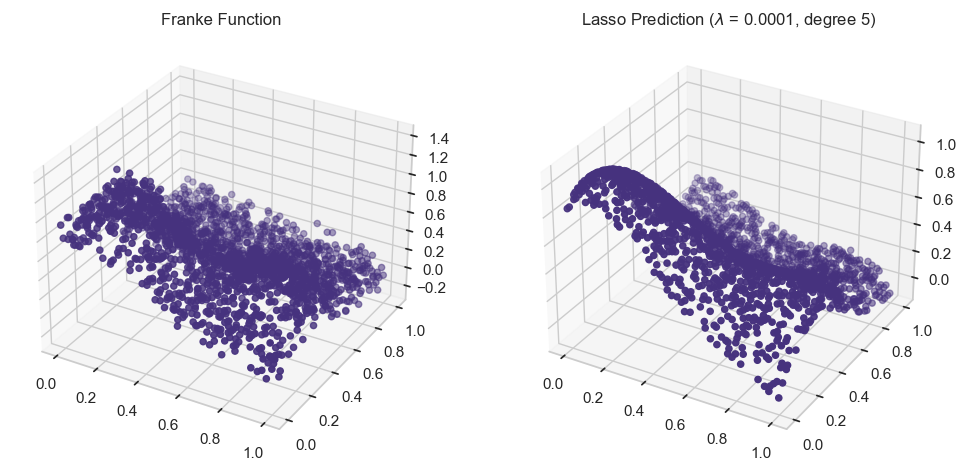

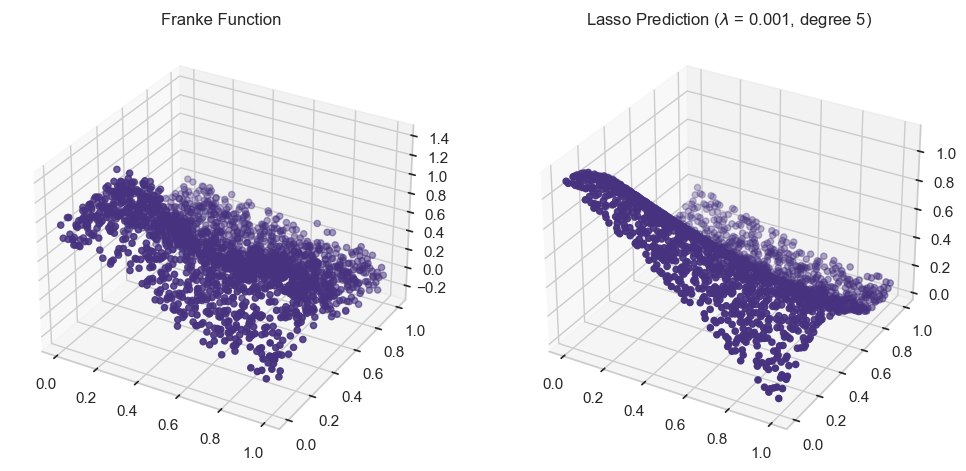

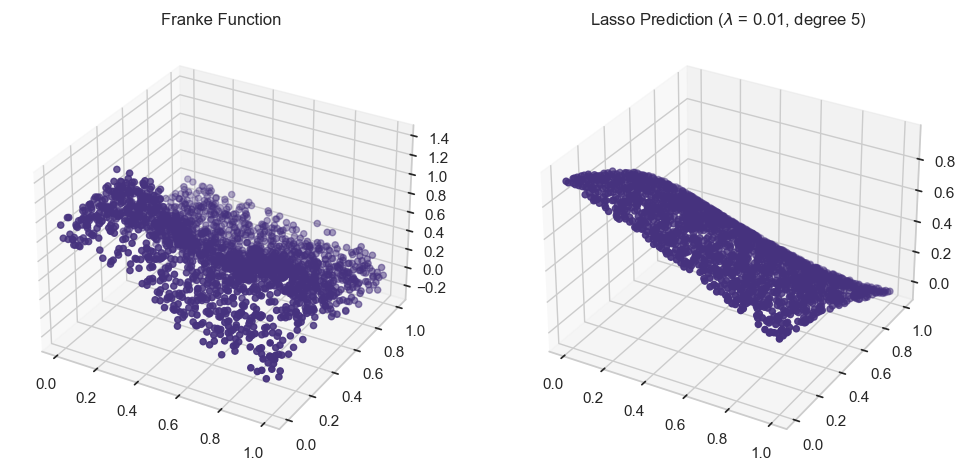

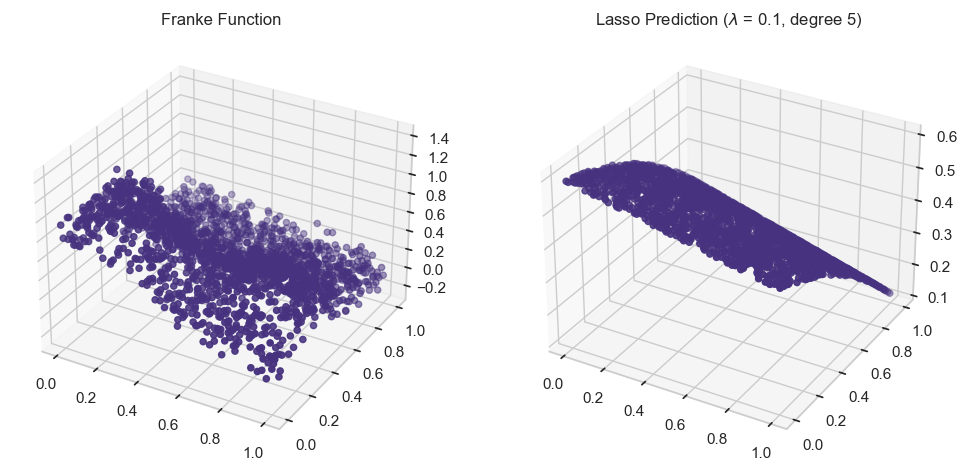

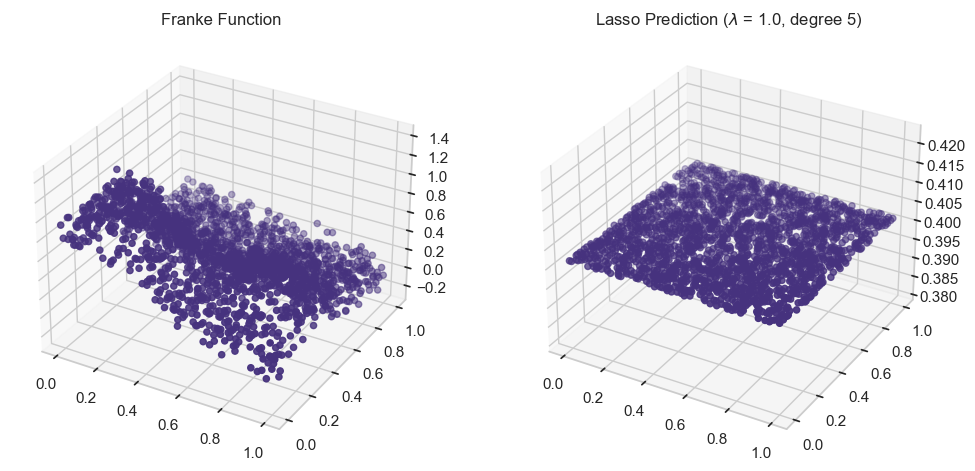

In [8]:
# Making data
n = 100
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
x, y = np.meshgrid(x,y)
# Unraveling to n^2-arrays
x = x.ravel()
y = y.ravel()

k = .1 # noise coefficient
z = FrankeFunction(x,y) + k*np.random.randn(n**2) # target variable with standard normal noise

p = 5 # highest polynomial degree 
N = np.arange(p+1) # for looping and plotting later
L = [int((p+1)*(p+2)/2) for p in N] # beta lengths
l = L[-1] # greatest beta length

logmin, logmax, m = -4, 0, 5 # logspce start, end, number of lambda values
llambdas = np.logspace(logmin, logmax, m)

beta_values = np.zeros((p+1, l, m))
MSE_train, MSE_test = np.zeros((p+1, m)), np.zeros((p+1, m))
R2_train, R2_test = np.zeros((p+1, m)), np.zeros((p+1, m))

for i in N:
    # we stack the values of x and y beside each other
    X = np.column_stack((x,y))

    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=3)

    for idx, lmbd in enumerate(llambdas):
        # we use pipeline to fit our model
        pipeline = make_pipeline(
            PolynomialFeatures(degree=i),
            StandardScaler(),
            Lasso(alpha=lmbd, max_iter=64_000))

        pipeline.fit(X_train,z_train)
        z_tilde = pipeline.predict(X_train)
        z_predict = pipeline.predict(X_test)

        MSE_train[i, idx] = mean_squared_error(z_train, z_tilde)
        MSE_test[i, idx] = mean_squared_error(z_test, z_predict)
        R2_train[i, idx] = r2_score(z_train, z_tilde)
        R2_test[i, idx] = r2_score(z_test, z_predict)

        coefs = pipeline.named_steps['lasso'].coef_

        beta_values[i,:len(coefs),idx] = coefs

        if i == N[-1]: 
            plotting_test_values(X_test, z_test, z_predict, 100, lmbd, i)

### Plotting MSE and $R^2$-score as a function of $\lambda$ and polynomial degree

In [ ]:
# -- MSE
# Test data
heatmap(N[1:], llambdas, MSE_test*1000, r"Test data MSE (scale $10^{-3}$)")
plt.savefig("../Latex/Images/heatmap_lasso_testMSE_franke.png", bbox_inches="tight"); plt.plot()

# Training data
heatmap(N[1:], llambdas, MSE_train*1000, r"Training data MSE (scale $10^{-3}$)")
plt.savefig("../Latex/Images/heatmap_lasso_trainMSE_franke.png", bbox_inches="tight"); plt.plot()

# -- R2-score
# Test data
heatmap(N[1:], llambdas, R2_test*1000, r"Test data $R^2$-score (scale $10^{-3}$)", float_precision=1)
plt.savefig("../Latex/Images/heatmap_lasso_testR2_franke.png", bbox_inches="tight"); plt.plot()

# Training data
heatmap(N[1:], llambdas, R2_train*1000, r"Training data $R^2$-score (scale $10^{-3}$)", float_precision=1)
plt.savefig("../Latex/Images/heatmap_lasso_trainR2_franke.png", dpi=100, bbox_inches='tight', facecolor='w'); plt.plot()

### Plotting the $\beta$ coefficents

Plots the beta parameters for degree 3, 4 and 5

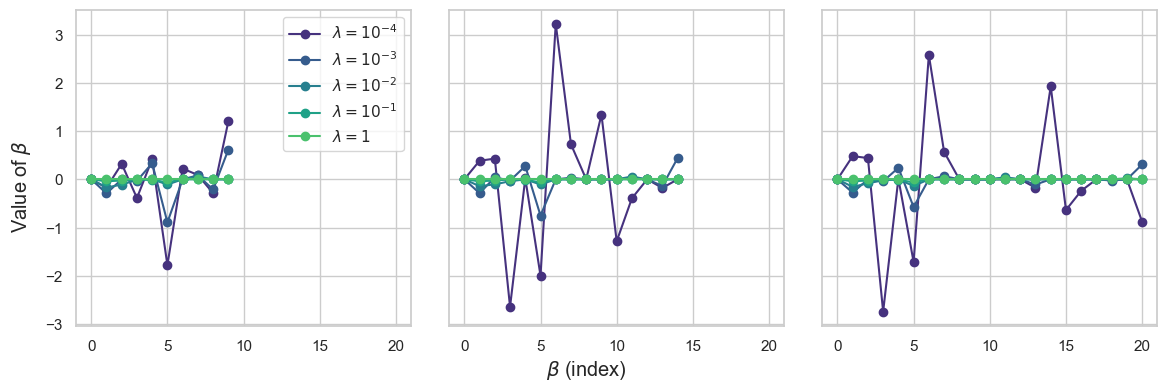

In [9]:
fig, axs = plt.subplots(1,3, figsize=(12, 4), sharex=True, sharey=True); fig.tight_layout()
axs = axs.flatten()

legend_vals = [r'$\lambda = 10^{-4}$', r'$\lambda = 10^{-3}$', r'$\lambda = 10^{-2}$', 
               r'$\lambda = 10^{-1}$', r'$\lambda = 1$']

for i,l in enumerate(L):
    if i < 3: continue
    axs[i-3].plot(np.arange(l), beta_values[i][:l], 'o-', label=legend_vals)
    if i == 3:
        axs[i-3].legend(loc='best')


fig.supxlabel(r'$\beta$ (index)')
fig.supylabel(r'Value of $\beta$')

plt.subplots_adjust(left=0.075, bottom=0.15)
plt.show()